# Побудова прогнозів

## Завдання

Використовуючи датасет з файлу **cardox.csv (об’єми продажів мережі супермаркетів)** виконайте наступну роботу:

- Проведіть попередній аналіз даних
- Скорегуйте виявлені аномалії
- Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)
- Оберіть модель і проведіть оцінку її метрик
- Проведіть кінцеву діагностику для отриманої моделі
- Виконайте прогноз на 30 років
- Збережіть результати прогнозування у файл

### Розв'язок

In [204]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [205]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()

In [206]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [207]:
df=pd.read_csv("cardox.csv", index_col='date')
df.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [208]:
df.shape

(729, 1)

In [209]:
df.index = pd.to_datetime(df.index)

[<AxesSubplot: >]

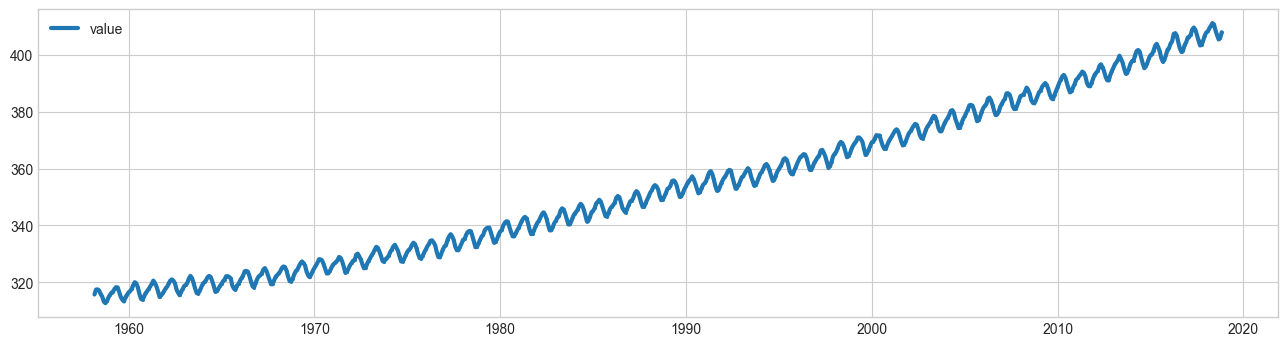

In [210]:
plot(df, ts_linewidth=3)

In [211]:
df.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


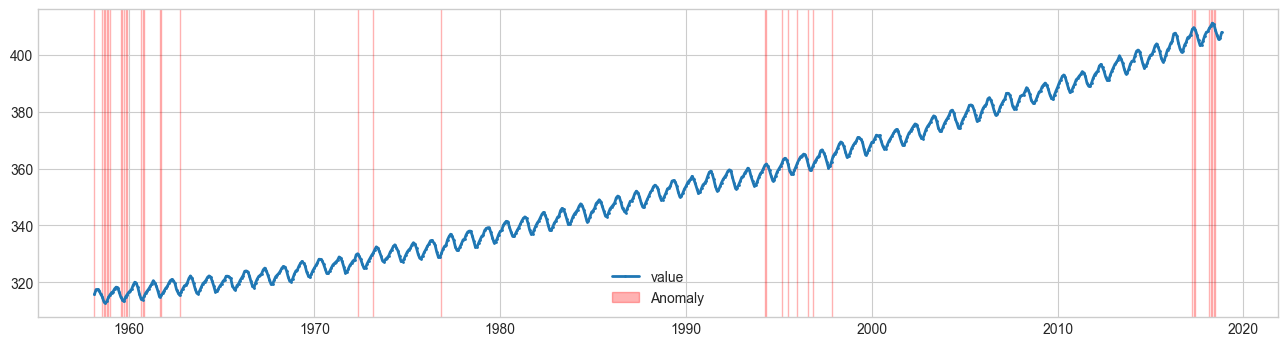

In [212]:
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [213]:
anomalies[anomalies]

date
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

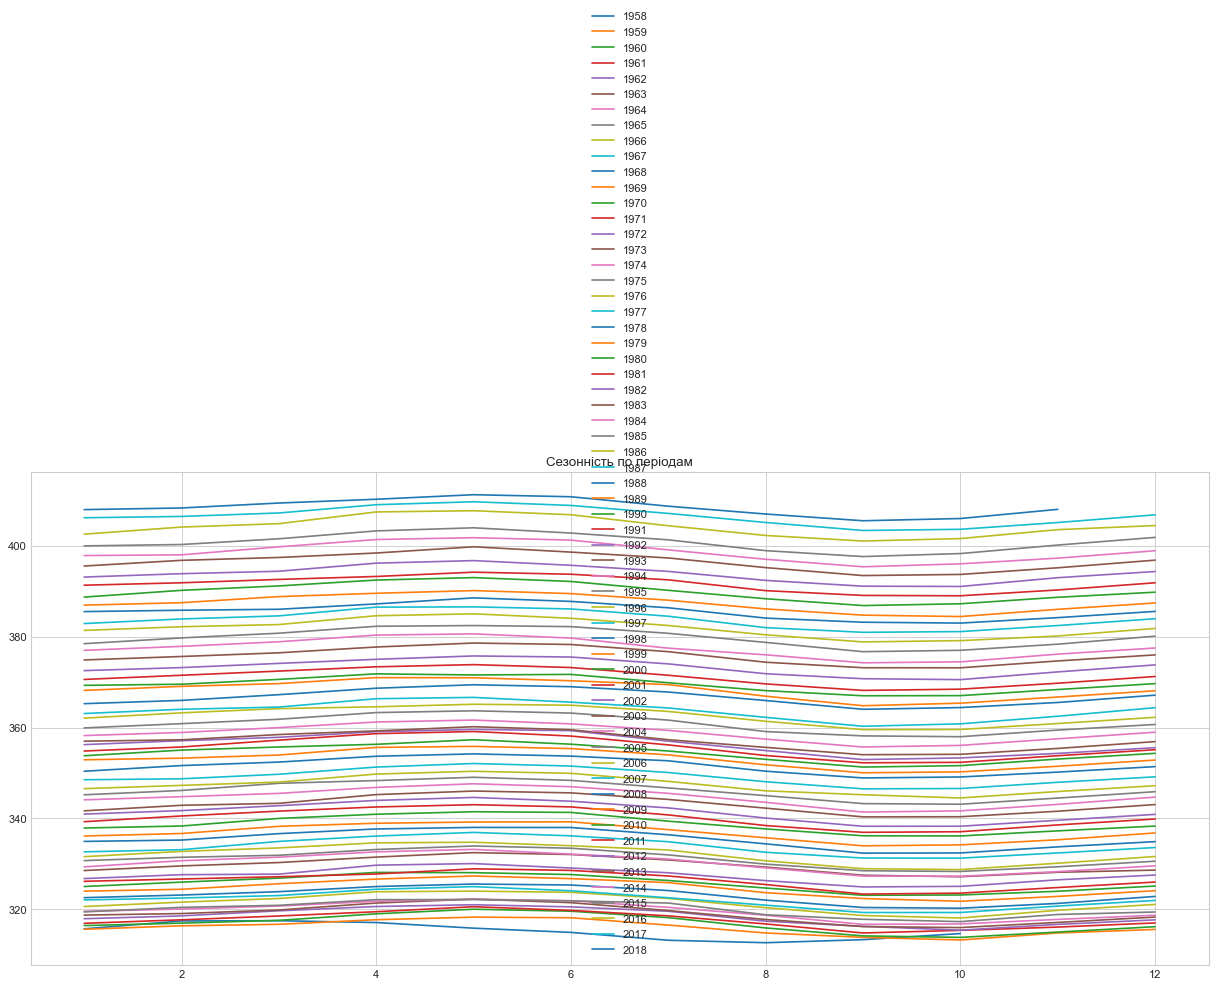

In [214]:
sesonal(df,12)

Text(0.5, 0.98, 'Мультиплікатива модель')

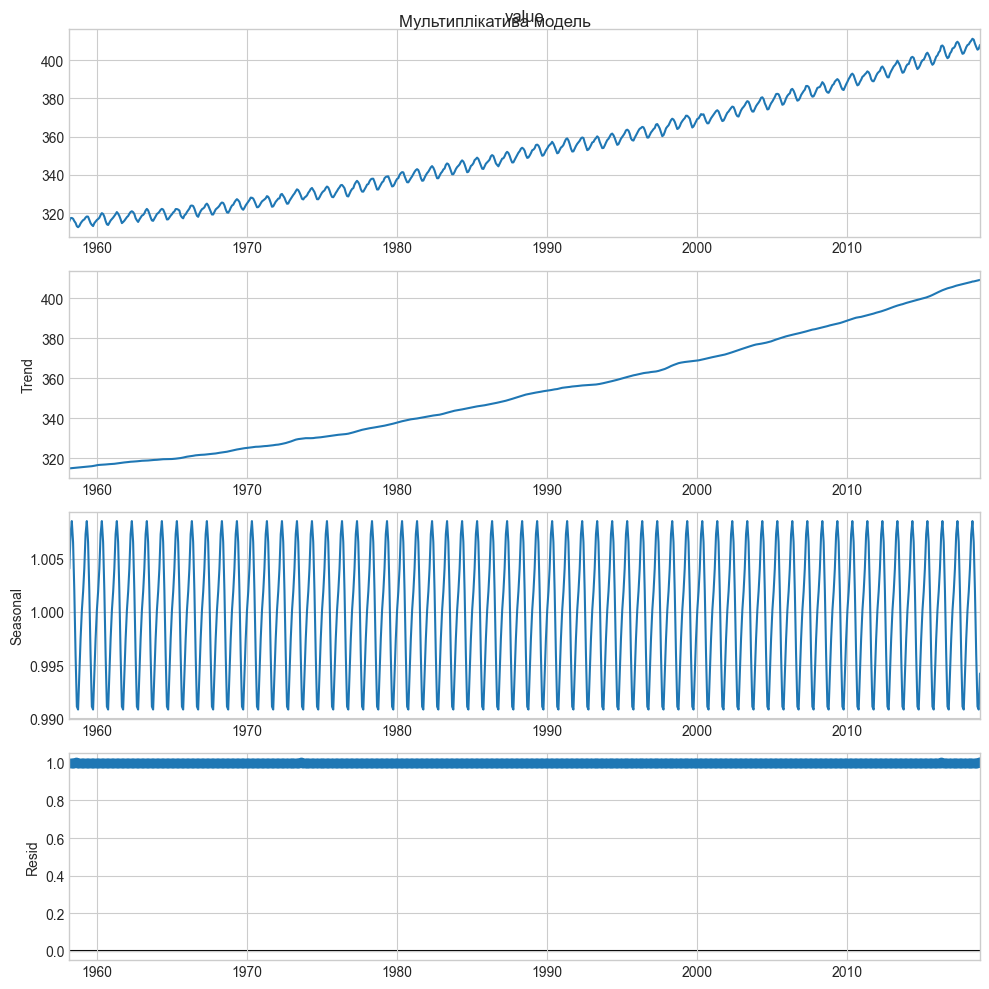

In [215]:
# декомпозицiя 
result_M = seasonal_decompose(df.value, model='multiplicative', extrapolate_trend=12)

# Побудова графіка
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель')

In [216]:
df.value['2000']

date
2000-01-01    369.29
2000-02-01    369.54
2000-03-01    370.60
2000-04-01    371.82
2000-05-01    371.58
2000-06-01    371.70
2000-07-01    369.86
2000-08-01    368.13
2000-09-01    367.00
2000-10-01    367.03
2000-11-01    368.37
2000-12-01    369.67
Name: value, dtype: float64

In [217]:
result_M.seasonal['2000']

date
2000-01-01    1.000135
2000-02-01    1.001929
2000-03-01    1.004054
2000-04-01    1.007302
2000-05-01    1.008530
2000-06-01    1.006555
2000-07-01    1.001988
2000-08-01    0.995917
2000-09-01    0.991096
2000-10-01    0.990812
2000-11-01    0.994200
2000-12-01    0.997482
Name: seasonal, dtype: float64

In [218]:
result_M.trend['2000']

date
2000-01-01    368.840417
2000-02-01    368.908750
2000-03-01    369.051250
2000-04-01    369.211667
2000-05-01    369.349583
2000-06-01    369.483750
2000-07-01    369.603333
2000-08-01    369.739583
2000-09-01    369.897917
2000-10-01    370.038750
2000-11-01    370.197917
2000-12-01    370.355417
Name: trend, dtype: float64

Text(0.5, 0.98, 'Адитивная модель')

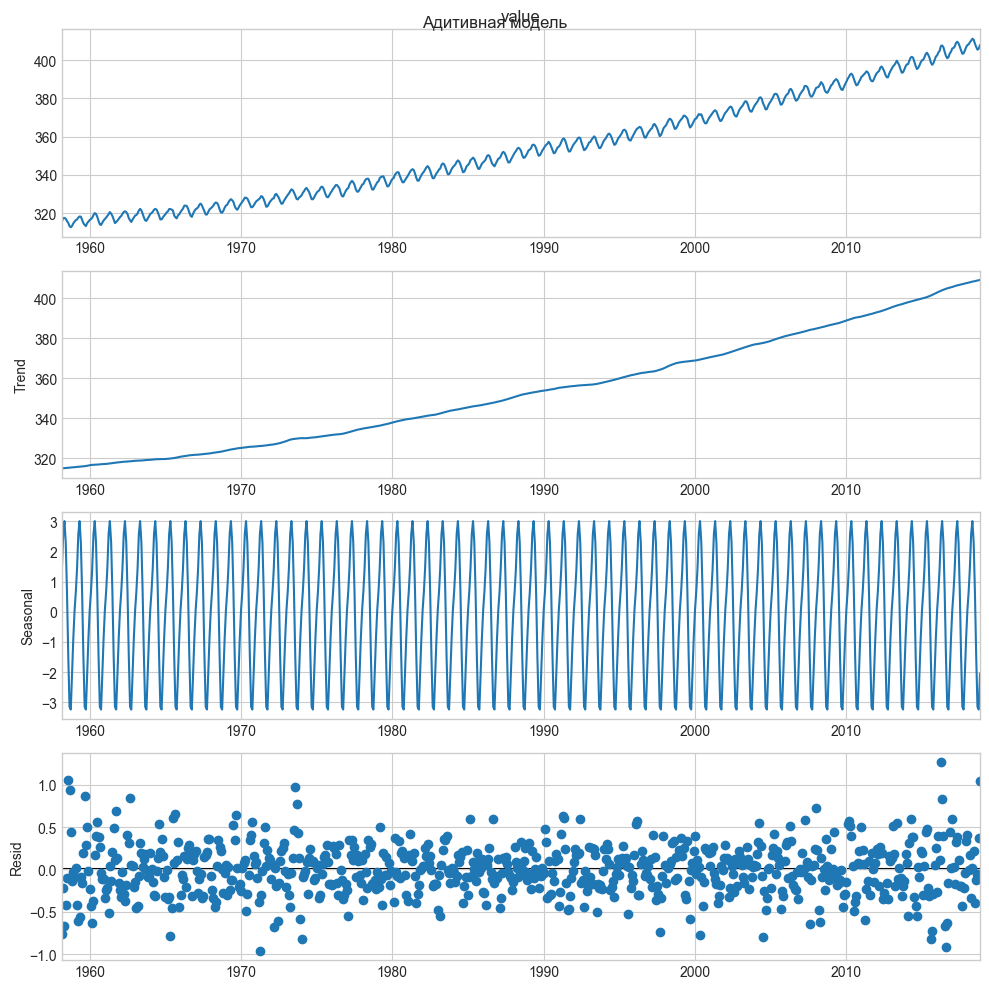

In [219]:
# Decompose 
result_A = seasonal_decompose(df.value, model='additive', extrapolate_trend=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Адитивная модель')

In [220]:
result_A.seasonal['2000']

date
2000-01-01    0.059289
2000-02-01    0.688213
2000-03-01    1.435042
2000-04-01    2.579879
2000-05-01    3.010959
2000-06-01    2.308198
2000-07-01    0.687431
2000-08-01   -1.456150
2000-09-01   -3.152087
2000-10-01   -3.241776
2000-11-01   -2.041328
2000-12-01   -0.877669
Name: seasonal, dtype: float64

In [221]:
result_M.seasonal['2000']

date
2000-01-01    1.000135
2000-02-01    1.001929
2000-03-01    1.004054
2000-04-01    1.007302
2000-05-01    1.008530
2000-06-01    1.006555
2000-07-01    1.001988
2000-08-01    0.995917
2000-09-01    0.991096
2000-10-01    0.990812
2000-11-01    0.994200
2000-12-01    0.997482
Name: seasonal, dtype: float64

In [222]:
anomalies[anomalies]

date
1958-03-01    True
1958-08-01    True
1958-09-01    True
1958-10-01    True
1958-11-01    True
1958-12-01    True
1959-01-01    True
1959-08-01    True
1959-09-01    True
1959-10-01    True
1959-11-01    True
1959-12-01    True
1960-09-01    True
1960-10-01    True
1960-11-01    True
1961-09-01    True
1961-10-01    True
1962-10-01    True
1972-05-01    True
1973-03-01    True
1976-11-01    True
1994-04-01    True
1994-05-01    True
1995-03-01    True
1995-07-01    True
1996-01-01    True
1996-08-01    True
1996-11-01    True
1997-11-01    True
2017-04-01    True
2017-05-01    True
2017-06-01    True
2018-03-01    True
2018-04-01    True
2018-05-01    True
2018-06-01    True
2018-07-01    True
dtype: bool

In [223]:
df.loc['1958-09-01']=df.loc['1959-09-01']
df.loc['1958-10-01']=df.loc['1960-10-01']
df.loc['1958-11-01']=df.loc['1959-11-01']
df.loc['1959-10-01']=df.loc['1960-10-01']

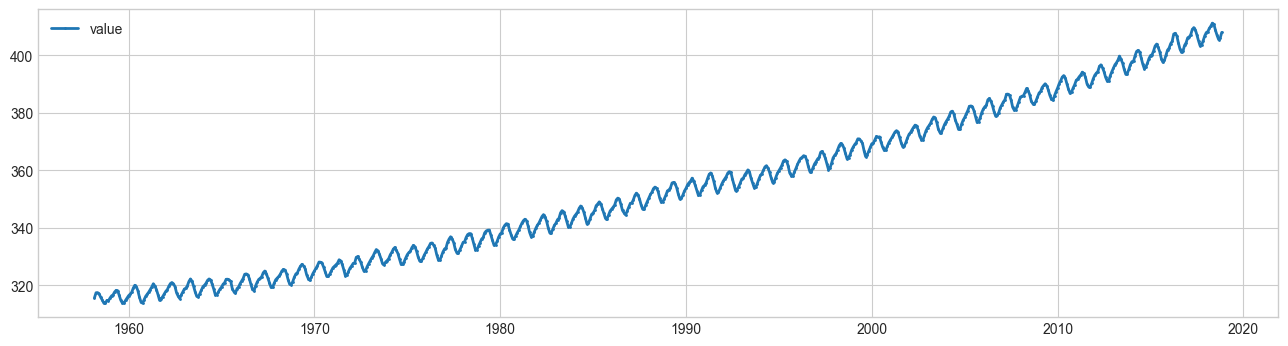

In [224]:
outlier_detector = OutlierDetector(LocalOutlierFactor())
anomalies = outlier_detector.fit_detect(df)
# contamination=0.01
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

In [225]:
df

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


In [226]:
train=df['1958':'2010']
train

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2010-08-01,388.35
2010-09-01,386.85
2010-10-01,387.24


In [227]:
test=df['2010':'2018']
test

,value
date,
2010-01-01,388.71
2010-02-01,390.20
2010-03-01,391.17
2010-04-01,392.46
2010-05-01,393.00
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


## Модель Хольта-Вінтерса

In [228]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [229]:
fit1.params

{'smoothing_level': 0.717821057004493,
 'smoothing_trend': 0.009227990269480044,
 'smoothing_seasonal': 4.3276714964679884e-17,
 'damping_trend': nan,
 'initial_level': 316.29461701641554,
 'initial_trend': 0.08504078308416807,
 'initial_seasons': array([0.99835919, 1.0015559 , 1.00272596, 1.00082442, 0.99628871,
        0.99021238, 0.98537767, 0.98509598, 0.98840482, 0.99167383,
        0.99433126, 0.99620267]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [230]:
fit1.fittedvalues

date
1958-03-01    315.860539
1958-04-01    316.847681
1958-05-01    317.738964
1958-06-01    317.051723
1958-07-01    315.735795
                 ...    
2010-08-01    388.087643
2010-09-01    386.533484
2010-10-01    386.805445
2010-11-01    388.576398
2010-12-01    390.088851
Length: 634, dtype: float64

In [231]:
fit1.forecast(96)

2011-01-01    391.077414
2011-02-01    391.972074
2011-03-01    392.979555
2011-04-01    394.397335
2011-05-01    395.017746
                 ...    
2018-08-01    403.805105
2018-09-01    401.990426
2018-10-01    402.032362
2018-11-01    403.540127
2018-12-01    405.032679
Freq: MS, Length: 96, dtype: float64

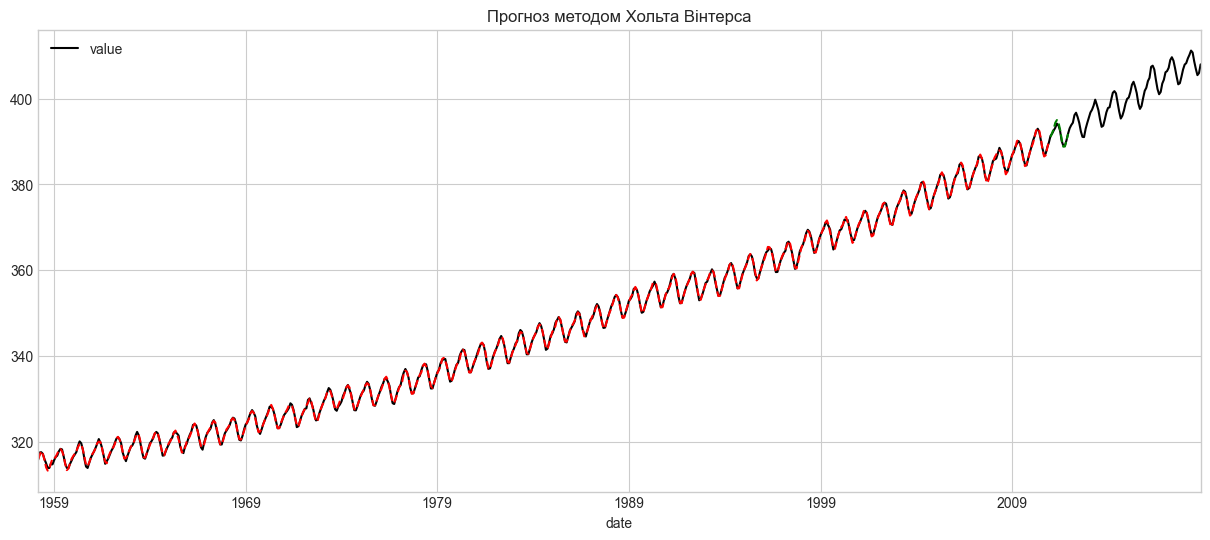

In [232]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Вiнтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

In [233]:
metrics(train, fit1.fittedvalues)

Тест на стаціонарність:
	T-статистика = -6.847
	P-значення = 0.000
Критичне значення :
	1%: -3.4410277306083668 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8662510413264357 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.569278890210853 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.2322
MSE: 0.09
MAPE: 0.0007
MPE: 0.0
Стандартна похибка: 0.3


In [234]:
metrics(test, fit1.forecast(len(test)))

Тест на стаціонарність:
	T-статистика = -0.363
	P-значення = 0.916
Критичне значення :
	1%: -3.4942202045135513 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.889485291005291 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.5816762131519275 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 1.3736
MSE: 2.2999
MAPE: 0.0035
MPE: -0.0015
Стандартна похибка: 1.5165


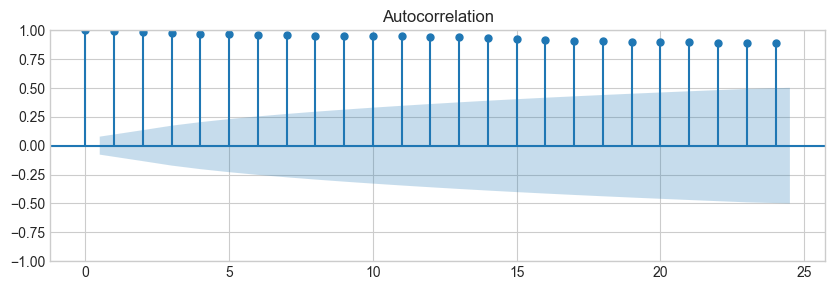

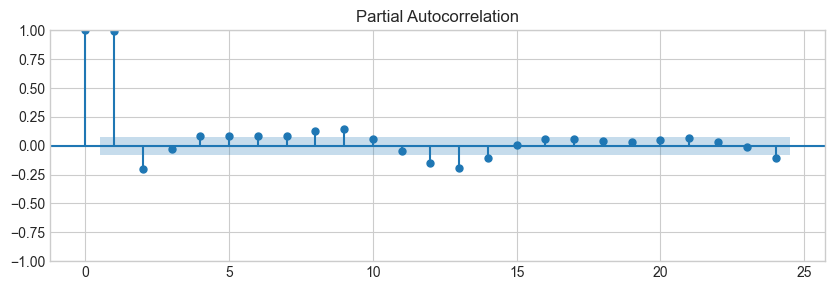

In [235]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(train.value, lags=24)
plot_pacf(train.value, lags=24)
plt.show()

## Модель ARIMA

In [236]:
model = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=431.874, Time=2.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2037.464, Time=0.94 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1355.973, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2041.397, Time=0.16 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=916.193, Time=3.07 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=635.426, Time=2.78 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=437.264, Time=5.91 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=455.188, Time=5.60 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1207.577, Time=0.60 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=5.35 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=511.823, Time=6.38 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=6.89 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=387.012, Time=2.54 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AI

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [237]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 12))

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2755.322      0.000       0.999       1.000
ar.S.L12       0.9995      0.000   2616.509      0.000       0.999       1.000
ma.S.L12      -0.8927      0.021    -42.115      0.000      -0.934      -0.851
sigma2         0.1031      0.003     32.790      0.000       0.097       0.109


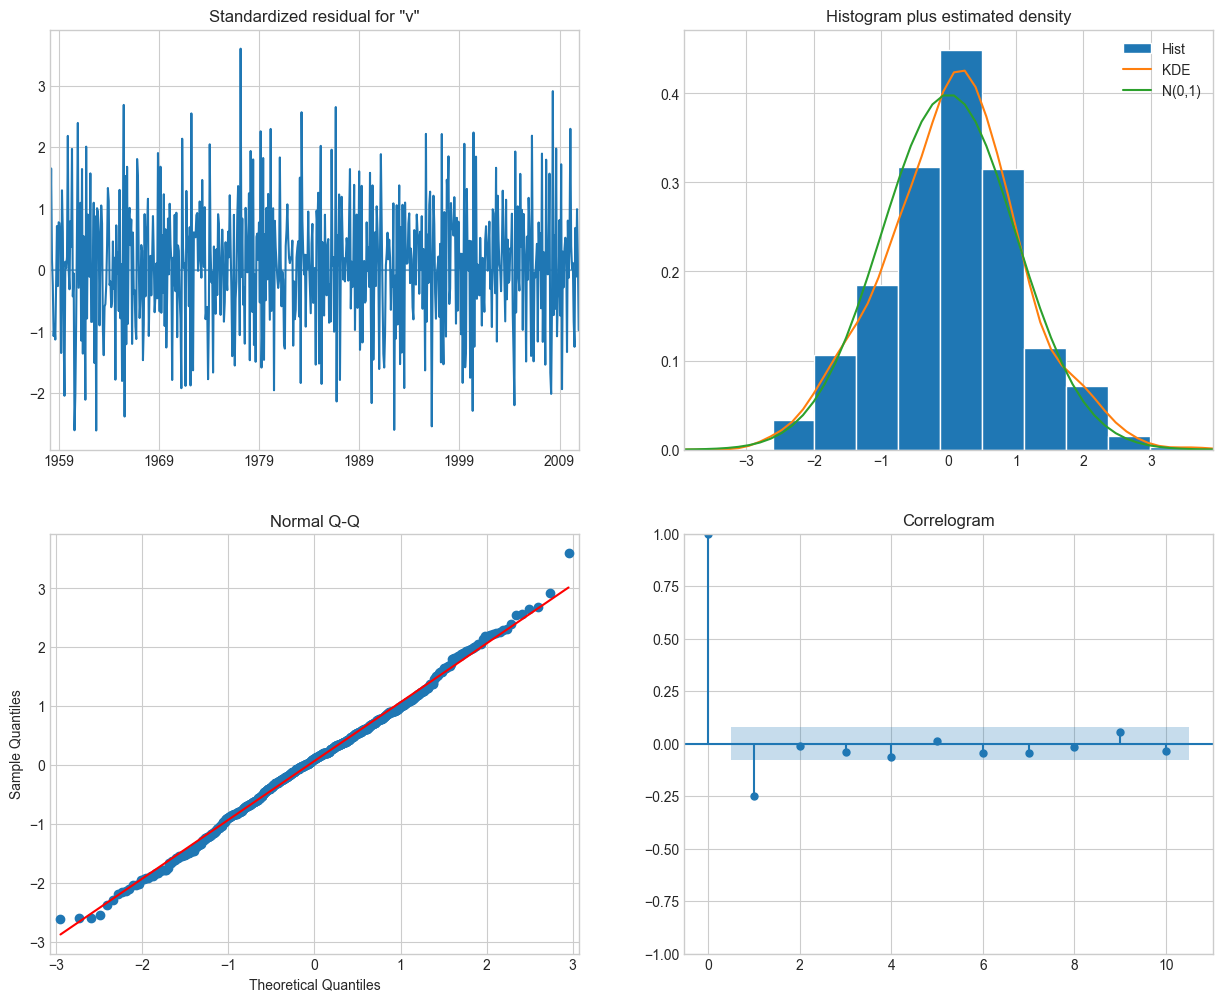

In [238]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [239]:
predict=results.get_prediction()
predict.predicted_mean[:10]

1958-03-01      0.000000
1958-04-01    315.709763
1958-05-01    317.323590
1958-06-01    317.359831
1958-07-01    316.981906
1958-08-01    315.845929
1958-09-01    315.009533
1958-10-01    314.052638
1958-11-01    314.071257
1958-12-01    314.933946
Freq: MS, Name: predicted_mean, dtype: float64

In [240]:
predict=results.get_prediction(start='1958-03-01')
metrics(train['1958-03-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -7.009
	P-значення = 0.000
Критичне значення :
	1%: -3.4410627157395908 - Дані  стационарні з ймовірністю 99% відсотків
	5%: -2.8662664495424255 - Дані  стационарні з ймовірністю 95% відсотків
	10%: -2.5692871001333266 - Дані  стационарні з ймовірністю 90% відсотків
MAD: 0.763
MSE: 157.3326
MAPE: 0.0023
MPE: 0.0016
Стандартна похибка: 12.5432


In [241]:
predict=results.get_prediction(start='2018', end='2048')

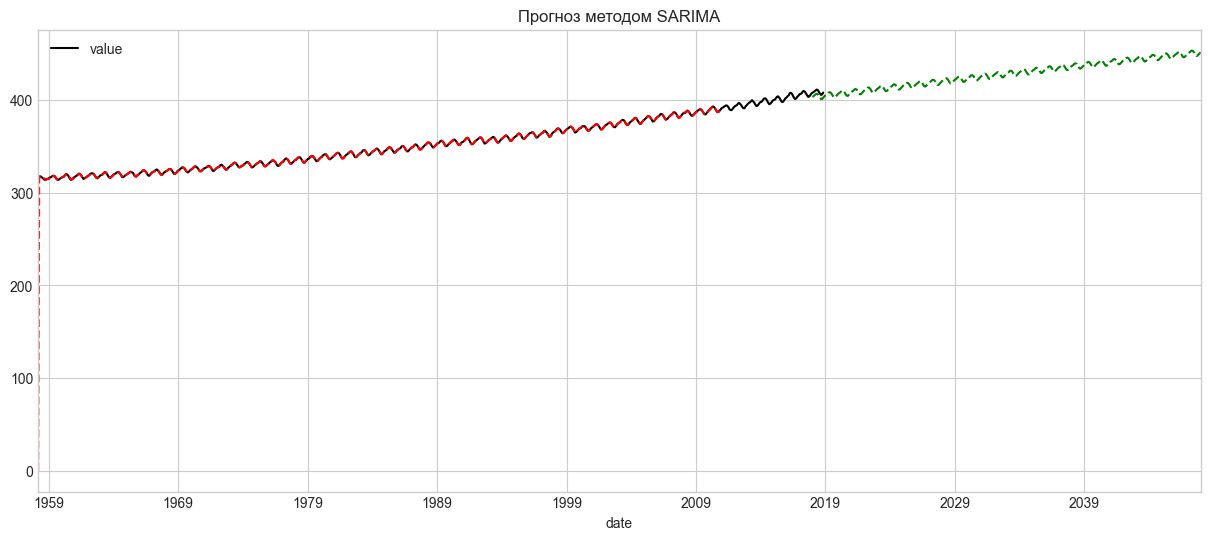

In [242]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [243]:
predict=results.get_prediction(start='2010-01-01', end='2018-11-01')
metrics(test, predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = 0.423
	P-значення = 0.982
Критичне значення :
	1%: -3.4961490537199116 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.8903209639580556 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.5821223452518263 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 2.0776
MSE: 7.1359
MAPE: 0.0051
MPE: 0.005
Стандартна похибка: 2.6713


## Висновок

**Для прогнозування даних обираємо модель Хольта-Вінтерса, томущо метрики цієї моделі для даної вибірки показують кращий результат**

## Модель Хольта-Вінтерса для прогнозування даних

In [244]:
df

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86
...,...
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51


In [245]:
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='mul').fit()

In [246]:
fit1.params

{'smoothing_level': 0.6472159636002314,
 'smoothing_trend': 0.011709290872718024,
 'smoothing_seasonal': 0.051117133816803356,
 'damping_trend': nan,
 'initial_level': 316.82259087086646,
 'initial_trend': 0.07969152401001404,
 'initial_seasons': array([0.99673118, 1.00002771, 1.00135324, 0.9996084 , 0.99541882,
        0.98949544, 0.98469192, 0.98419822, 0.98755904, 0.99042239,
        0.99296826, 0.99479125]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [247]:
fit1.fittedvalues

date
1958-03-01    315.866385
1958-04-01    316.888017
1958-05-01    317.755133
1958-06-01    317.117409
1958-07-01    315.857407
                 ...    
2018-07-01    409.058118
2018-08-01    406.661917
2018-09-01    405.254409
2018-10-01    405.535946
2018-11-01    407.316492
Length: 729, dtype: float64

In [248]:
prediction_for_30_years = fit1.forecast(360)
prediction_for_30_years

2018-12-01    409.270913
2019-01-01    410.502992
2019-02-01    411.320493
2019-03-01    412.367286
2019-04-01    413.905270
                 ...    
2048-07-01    479.510881
2048-08-01    476.987475
2048-09-01    475.063875
2048-10-01    475.189899
2048-11-01    476.868614
Freq: MS, Length: 360, dtype: float64

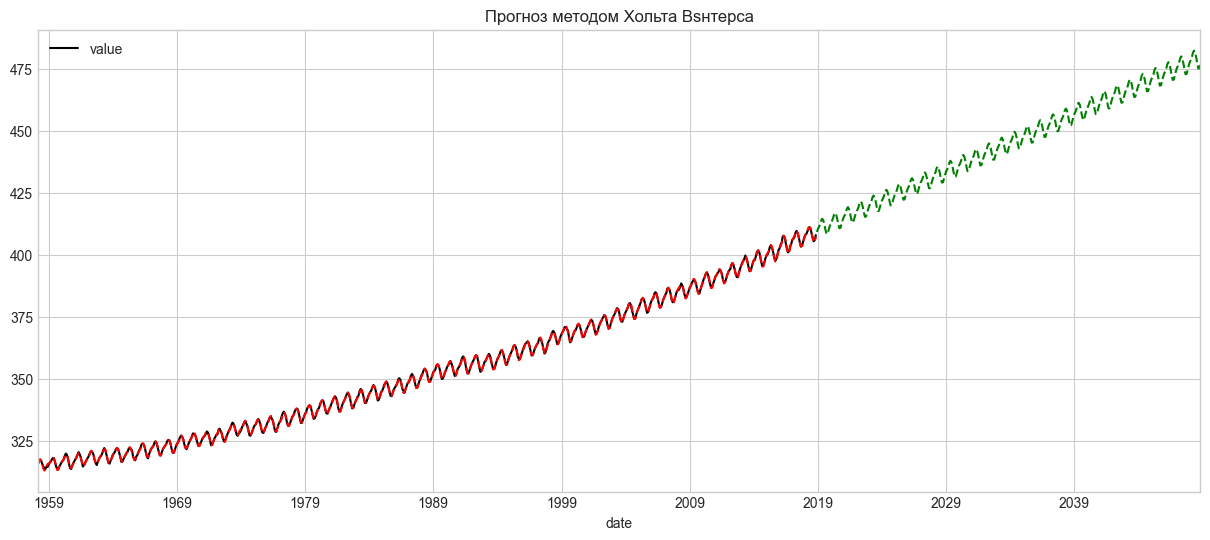

In [249]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта Вsнтерса" )
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit1.forecast(360).plot(ax=ax, style='--', color='green')
plt.show()

In [250]:
prediction_for_30_years.to_csv('prediction_for_30_years.csv')